In [2]:
import pandas as pd
import math as mt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import newaxis
import time
import holidays
import pickle
import warnings
warnings.filterwarnings("ignore") # may not always be the best thing to do...
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from google.colab import files
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

## Link colab to your google drive
from google.colab import drive
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Nilm metric
def metric_nilm(dataframe_y_true, dataframe_y_pred):
    score = 0.0
    test = dataframe_y_true[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    pred = dataframe_y_pred[~dataframe_y_true['washing_machine'].isna()]['washing_machine']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*5.55
    test = dataframe_y_true[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    pred = dataframe_y_pred[~dataframe_y_true['fridge_freezer'].isna()]['fridge_freezer']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*49.79
    test = dataframe_y_true[~dataframe_y_true['TV'].isna()]['TV']
    pred = dataframe_y_pred[~dataframe_y_true['TV'].isna()]['TV']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*14.57
    test = dataframe_y_true[~dataframe_y_true['kettle'].isna()]['kettle']
    pred = dataframe_y_pred[~dataframe_y_true['kettle'].isna()]['kettle']
    score += mt.sqrt(sum((pred - test)**2)/len(test))*4.95
    score /= 74.86
    return score

# Custom metric for fit
def custom_metric(y_true, y_pred):
        score = mt.sqrt(sum((y_pred.get_label() - y_true) ** 2) / len(y_true)) * 14.57
        score /= 74.86
        return "nilm", score

# Create final y dataframe
def create_y_predictions(x_out_old, x_out, best_model):
  Y_out_temp = best_model.predict(x_out)
  df = pd.DataFrame(Y_out_temp)
  Y_out = pd.DataFrame(x_out_old["time_step"])
  Y_out["washing_machine"] = df.iloc[:,0]
  Y_out["fridge_freezer"] = df.iloc[:,1]
  Y_out["TV"] = df.iloc[:,2]
  Y_out["kettle"] = df.iloc[:,3]
  Y_out.index = Y_out.time_step #ligne de nao
  Y_out.to_csv('y_out.csv', header=True,index=False)
  print(Y_out)
  files.download("y_out.csv")
  return Y_out

#Modif of output
def modif_output(y_pred2_df):
  y_pred2_df['kettle'] = y_pred2_df['kettle'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['TV'] = y_pred2_df['TV'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['fridge_freezer'] = y_pred2_df['fridge_freezer'].apply(lambda x : 0 if x<=1 else x)
  y_pred2_df['washing_machine'] = y_pred2_df['washing_machine'].apply(lambda x : 0 if x<=1 else x)
  return y_pred2_df

In [8]:
data = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/data.csv")
data.head()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,time_step,washing_machine,fridge_freezer,TV,kettle,month,day,hour,day_of_week,minute,n_days,is_holiday,is_weekend,sin_hour,cos_hour,sin_day,cos_day,sin_dow,cos_dow,peak_hours,is_breakfast,is_teatime,is_evening,avg_hourly_consumption,avg_day_of_weekly_consumption,avg_hourly_washing_machine,avg_day_of_weekly_washing_machine,avg_hourly_fridge_freezer,avg_day_of_weekly_fridge_freezer,avg_hourly_TV,avg_day_of_weekly_TV,avg_hourly_kettle,...,log_conso + 1,log_conso - 2,log_conso + 2,log_conso - 3,log_conso + 3,log_conso - 5,log_conso + 5,log_conso - 10,log_conso + 10,log_conso - 30,log_conso + 30,log_conso - 60,log_conso + 60,log_conso - 120,log_conso + 120,conso_normalised,conso / mvg_std_10,conso / mvg_std_30,conso / mvg_std_60,conso_trend,conso_anomaly,conso_low,conso_cumsum_mvg_avg_30,moving_conso_mean_3,conso - mvg_avg_3,moving_conso_mean_5,conso - mvg_avg_5,conso_cumsum_mvg_avg_3,conso_cumsum_mvg_avg_5,conso_cumsum_mvg_avg_10,conso_cumsum_mvg_avg_15,conso_cumsum_mvg_avg_20,conso_cumsum_mvg_avg_60,cumsum_diff_3,cumsum_diff_5,cumsum_diff_10,cumsum_diff_15,cumsum_diff_20,cumsum_diff_30,cumsum_diff_60
0,550.4000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:01:00,0.0,79.2000,7.0,0.0,3,17,0,6,1,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.307370,6.310645,6.308645,6.310645,6.308766,6.310645,6.309251,6.310645,6.305180,6.310645,6.369730,6.310645,6.424058,6.310645,6.288849,473.890573,802.337957,69.811813,22.620646,520.917237,0,0,4.382633,549.433333,0.966667,549.31152,1.08848,0.966667,1.088480e+00,1.12024,3.326827,5.96637,-14.83883,0.000000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000
1,548.6000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:02:00,0.0,78.0000,7.0,0.0,3,17,0,6,2,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.308645,6.310645,6.308766,6.310645,6.307900,6.310645,6.307135,6.310645,6.303534,6.310645,6.356108,6.310645,6.293543,6.310645,6.289509,472.090573,802.337957,69.811813,22.620646,520.827729,0,0,6.965267,549.433333,-0.833333,549.31152,-0.71152,0.133333,3.769600e-01,0.44048,4.853653,10.13274,-31.47766,-0.700000,-0.70000,-0.7000,-0.7000,-0.7000,-0.7000,-0.7000
2,549.3000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:03:00,0.0,76.9000,7.0,0.0,3,17,0,6,3,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.308766,6.310645,6.307900,6.310645,6.309251,6.310645,6.310311,6.310645,6.303900,6.310645,6.352629,6.310645,6.293789,6.310645,6.276435,472.790573,802.337957,69.811813,22.620646,520.738222,0,0,10.247900,549.433333,-0.133333,549.31152,-0.01152,0.000000,3.654400e-01,0.46072,7.080480,14.99911,-47.41649,-0.411133,-0.06670,-0.0667,-0.0667,-0.0667,-0.0667,-0.0667
3,549.3667,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:04:00,0.0,76.1111,7.0,0.0,3,17,0,6,4,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,6.307900,6.307370,6.309251,6.310645,6.307135,6.310645,6.308908,6.310645,6.289344,6.310645,6.351584,6.310645,6.292495,6.310645,6.422882,472.857273,802.337957,69.811813,22.620646,520.648714,0,0,13.597233,549.088900,0.277800,549.31152,0.05518,0.277800,4.206200e-01,0.54766,9.374007,19.93218,-63.28862,0.572767,0.47580,0.4758,0.4758,0.4758,0.4758,0.4758
4,548.8909,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:05:00,0.0,75.2727,7.0,0.0,3,17,0,6,5,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,

# Model 0 : 36.3 platform, 38.4 local

## 1. First fit an XGBoost on all four appliances. 

In [0]:
removed_features = ["expanding_conso_mean_10","expanding_conso_max_10", "expanding_conso_min_10",
                    "expanding_conso_median_10", "expanding_conso_std_10", "expanding_conso_mean_30", 
                    "expanding_conso_max_30", "expanding_conso_min_30", "expanding_conso_median_30",
                    "expanding_conso_std_30", "expanding_conso_mean_60", "expanding_conso_max_60",
                    "expanding_conso_min_60", "expanding_conso_median_60", "expanding_conso_std_60",]

In [0]:
temp_features = ["rolling_std_future_5", "rolling_std_future_10", "rolling_std_past_5", "rolling_std_past_10",
                 "rolling_std_future_3", "rolling_std_past_3","rolling_max_5", "rolling_max_3",]

In [0]:
selected_features =  ['consumption', 
                      'conso - 1', 'conso - 2', 'conso - 3', 'conso - 5', 'conso - 10', 'conso - 30', 'conso - 60',
                      'conso + 1', 'conso + 2', 'conso + 3', 'conso + 5', 'conso + 10', 'conso + 30', 'conso + 60',
                      'moving_conso_mean_10','moving_conso_mean_30', 'moving_conso_mean_60', 
                      'moving_conso_max_10', 'moving_conso_max_30',  'moving_conso_max_60',
                      'moving_conso_min_10', 'moving_conso_min_30','moving_conso_min_60',
                      'moving_conso_std_10', 'moving_conso_std_30','moving_conso_std_60',
                      'moving_conso_mean_15', 'moving_conso_min_15', 'moving_conso_max_15',
                      'moving_conso_mean_20', 'moving_conso_min_20', 'moving_conso_max_20',
                      "conso - mvg_avg_10","conso - mvg_avg_30","conso - mvg_avg_60",
                      "conso - mvg_avg_15", "conso - mvg_avg_20",
                      "conso - avg_hourly_kettle",
                      'cos_hour', 'sin_hour', 'cos_day', 'sin_day', 'cos_dow', 'sin_dow',
                      'n_days', "hour", "month", "day_of_week",
                      'temperature','pressure',
                      'peak_hours', 
                      'avg_hourly_consumption', 'avg_hourly_washing_machine','avg_hourly_fridge_freezer','avg_hourly_TV','avg_hourly_kettle',
                      'avg_day_of_weekly_consumption','avg_day_of_weekly_washing_machine','avg_day_of_weekly_fridge_freezer',
                      'avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                      ]

In [0]:
X = data.loc[:,selected_features]
y = data.loc[:, "washing_machine":"kettle"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [13]:
xgb_reg = XGBRegressor(n_estimators=300,
                       learning_rate = 0.1,
                       max_depth=3)
multi_reg = MultiOutputRegressor(xgb_reg,n_jobs=-1)
multi_reg.fit(X_train,y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            importance_type='gain',
                                            learning_rate=0.1, max_delta_step=0,
                                            max_depth=3, min_child_weight=1,
                                            missing=None, n_estimators=300,
                                            n_jobs=1, nthread=None,
                                            objective='reg:linear',
                                            random_state=0, reg_alpha=0,
                                            reg_lambda=1, scale_pos_weight=1,
                                            seed=None, silent=None, subsample=1,
                                            verbos

In [0]:
#Prepare y_pred to be able to use their custom metrics
y_pred = multi_reg.predict(X_test)
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.columns = ["washing_machine","fridge_freezer","TV","kettle"]
y_pred_df.index = y_test.index

#Prepare y_pred_train to be able to use their custom metrics
y_pred_train = multi_reg.predict(X_train)
y_pred_train_df = pd.DataFrame(y_pred_train)
y_pred_train_df.columns = ["washing_machine","fridge_freezer","TV","kettle"]
y_pred_train_df.index = y_train.index

In [15]:
metric_nilm(y_test, y_pred_df), metric_nilm(y_train, y_pred_train_df) 

(38.76375489339689, 30.677956215219567)

In [16]:
# Fridge freezer
pred = y_pred[:,1]
test = y_test.iloc[:,1]
mt.sqrt(sum((pred - test)**2)/len(test))*49.79/74.86

27.18033367860216

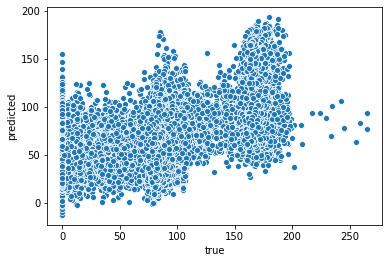

In [17]:
df = pd.DataFrame(y_pred_df["fridge_freezer"])
df["true"] = y_test["fridge_freezer"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [18]:
# TV
pred = y_pred[:,2]
test = y_test.iloc[:,2]
mt.sqrt(sum((pred - test)**2)/len(test))*14.57/74.86

2.975374859358945

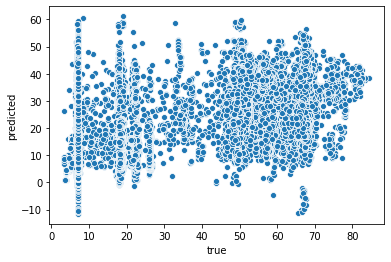

In [19]:
df = pd.DataFrame(y_pred_df["TV"])
df["true"] = y_test["TV"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [20]:
# Kettle
pred = y_pred[:,3]
test = y_test.iloc[:,3]
mt.sqrt(sum((pred - test)**2)/len(test))*4.95/74.86

5.345492831966233

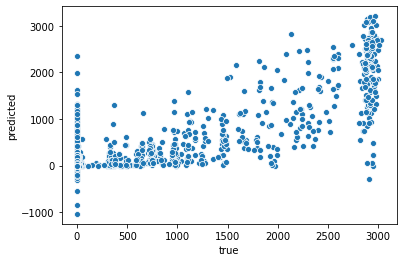

In [21]:
df = pd.DataFrame(y_pred_df["kettle"])
df["true"] = y_test["kettle"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

In [0]:
# Washing machine
pred = y_pred[:,0]
test = y_test.iloc[:,0]
mt.sqrt(sum((pred - test)**2)/len(test))*5.55/74.86

3.1925917435355213

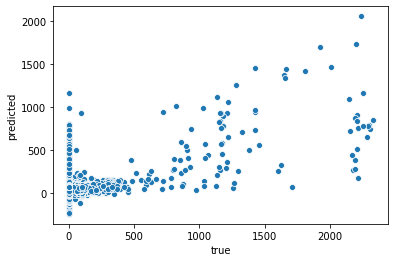

In [0]:
df = pd.DataFrame(y_pred_df["washing_machine"])
df["true"] = y_test["washing_machine"]
df.columns = ["predicted","true"]
sns.scatterplot(x= "true",y = "predicted", data=df)

## 2. Then predict TV on its own

- Started from the features for fridge freezer at 25
- Introduced early stopping after 3 rounds if the score doesn't improve: got us down from 10.5 to 3.47 locally
- Replacing conso normalised ff by conso normalised TV, and conso - avg hourly ff by TV+ adding rolling std 30 and 60 past and future, IDK what it did but lowering the lr was good idea and got me to 3.39 apparently

In [0]:
data = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/data.csv")
data.head()

,consumption,visibility,temperature,humidity,humidex,windchill,wind,pressure,time_step,washing_machine,fridge_freezer,TV,kettle,month,day,hour,day_of_week,minute,n_days,is_holiday,is_weekend,sin_hour,cos_hour,sin_day,cos_day,sin_dow,cos_dow,peak_hours,is_breakfast,is_teatime,is_evening,avg_hourly_consumption,avg_day_of_weekly_consumption,avg_hourly_washing_machine,avg_day_of_weekly_washing_machine,avg_hourly_fridge_freezer,avg_day_of_weekly_fridge_freezer,avg_hourly_TV,avg_day_of_weekly_TV,avg_hourly_kettle,...,is_winter,is_spring,is_summer,is_autumn,conso - mvg_avg_10,conso - mvg_avg_30,conso - mvg_avg_60,conso - mvg_avg_15,conso - mvg_avg_20,conso + 1,conso + 2,conso + 3,conso + 5,conso + 10,conso + 30,conso + 60,conso - 120,conso + 120,log_conso - 1,log_conso + 1,log_conso - 2,log_conso + 2,log_conso - 3,log_conso + 3,log_conso - 5,log_conso + 5,log_conso - 10,log_conso + 10,log_conso - 30,log_conso + 30,log_conso - 60,log_conso + 60,log_conso - 120,log_conso + 120,conso_normalised,conso / mvg_std_10,conso / mvg_std_30,conso / mvg_std_60,conso_trend,conso_anomaly
0,550.4000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:01:00,0.0,79.2000,7.0,0.0,3,17,0,6,1,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,1,0,0,0,1.4000,4.4000,-14.6000,3.4000,6.4000,548.6000,549.3000,549.3667,549.6333,547.4,583.9,616.5000,550.4,538.5333,6.310645,6.307370,6.310645,6.308645,6.310645,6.308766,6.310645,6.309251,6.310645,6.305180,6.310645,6.369730,6.310645,6.424058,6.310645,6.288849,473.890573,802.337957,69.811813,22.620646,520.917237,0
1,548.6000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:02:00,0.0,78.0000,7.0,0.0,3,17,0,6,2,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,1,0,0,0,-0.4000,2.6000,-16.4000,1.6000,4.6000,549.3000,549.3667,548.8909,548.4714,546.5,576.0,541.0667,550.4,538.8889,6.310645,6.308645,6.310645,6.308766,6.310645,6.307900,6.310645,6.307135,6.310645,6.303534,6.310645,6.356108,6.310645,6.293543,6.310645,6.289509,472.090573,802.337957,69.811813,22.620646,520.827729,0
2,549.3000,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:03:00,0.0,76.9000,7.0,0.0,3,17,0,6,3,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,1,0,0,0,0.3000,3.3000,-15.7000,2.3000,5.3000,549.3667,548.8909,549.6333,550.2159,546.7,574.0,541.2000,550.4,531.8889,6.307370,6.308766,6.310645,6.307900,6.310645,6.309251,6.310645,6.310311,6.310645,6.303900,6.310645,6.352629,6.310645,6.293789,6.310645,6.276435,472.790573,802.337957,69.811813,22.620646,520.738222,0
3,549.3667,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:04:00,0.0,76.1111,7.0,0.0,3,17,0,6,4,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,1,0,0,0,0.3667,3.3667,-15.6333,2.3667,5.3667,548.8909,549.6333,548.4714,549.4444,538.8,573.4,540.5000,550.4,615.7750,6.308645,6.307900,6.307370,6.309251,6.310645,6.307135,6.310645,6.308908,6.310645,6.289344,6.310645,6.351584,6.310645,6.292495,6.310645,6.422882,472.857273,802.337957,69.811813,22.620646,520.648714,0
4,548.8909,23.628652,6.529775,78.36236,6.533146,3.148034,20.547753,1006.555618,2013-03-17 00:05:00,0.0,75.2727,7.0,0.0,3,17,0,6,5,15781,0,1,0.0,1.0,-0.299363,-0.954139,-0.781831,0.62349,0,0,0,0,275.842073,315.713463,16.666658,9.116859,50.053807,49.695682,9.791535,14.698118,0.002574,...,1,0,0,0,-0.1091,2.8909,-16.1091,1.8909,4.8909,549.6333,548.4714,550.2159,548.4750,533.9,574.6,540.8000,550.4,640.8586,6.308766,6.309251,6.308645,6.307135,6.307370,6.310311,6.310645,6.307142,6.310645,6.280209,6.310645,

In [0]:
removed_features = ["expanding_conso_mean_10","expanding_conso_max_10", "expanding_conso_min_10", 
                    "expanding_conso_median_10", "expanding_conso_std_10", "expanding_conso_mean_30", 
                    "expanding_conso_max_30", "expanding_conso_min_30", "expanding_conso_median_30",
                    "expanding_conso_std_30", "expanding_conso_mean_60", "expanding_conso_max_60",
                    "expanding_conso_min_60", "expanding_conso_median_60", "expanding_conso_std_60",

                    'avg_day_of_weekly_washing_machine','avg_day_of_weekly_TV','avg_day_of_weekly_kettle',
                    'avg_day_of_weekly_consumption','avg_day_of_weekly_fridge_freezer',

                    "minutely_std_fridge_freezer", # all removed from fridge freezer

                    "rolling_std_future_5", "rolling_std_future_10", "rolling_std_past_5", "rolling_std_past_10",
                    "rolling_std_future_3", "rolling_std_past_3",
                    ]

In [0]:
features_TV = ['consumption', 
               'conso - 1',  'conso - 30', 'conso - 60','conso - 2','conso - 3', 'conso - 5','conso - 10',
               'conso + 1',  'conso + 30', 'conso + 60','conso + 2', 'conso + 3', 'conso + 5', 'conso + 10',
               'moving_conso_mean_10', 'moving_conso_mean_30', 'moving_conso_mean_60', 
               'moving_conso_max_10', 'moving_conso_max_30',  'moving_conso_max_60',
               'moving_conso_min_10', 'moving_conso_min_30','moving_conso_min_60',
               'moving_conso_std_10', 'moving_conso_std_30','moving_conso_std_60',
               'moving_conso_mean_15', 'moving_conso_min_15', 'moving_conso_max_15',
               'moving_conso_mean_20', 'moving_conso_min_20', 'moving_conso_max_20',
               "moving_conso_std_15", "moving_conso_std_20", 
               "conso / mvg_std_10", "conso / mvg_std_30","conso / mvg_std_60",
               "cons - mvg_avg_10",
               "cons - mvg_avg_15", "cons - mvg_avg_20","cons - mvg_avg_30","cons - mvg_avg_60",
               "conso_normalised",
               "conso_normalised_TV",  "conso - avg_hourly_TV", 
               'cos_hour', 'sin_hour',  'cos_day', 'sin_day', 'sin_dow', 'cos_dow',
               'n_days', "hour", "month", "day_of_week",
               'temperature','pressure','humidex', 'windchill',
               'peak_hours',
               'avg_hourly_consumption','avg_hourly_fridge_freezer',
               'avg_hourly_washing_machine', 'avg_hourly_TV','avg_hourly_kettle',
               "conso - rolling_mean_5", "conso - rolling_mean_3",
               "conso - rolling_mean_30",
               "rolling_std_future_5", "rolling_std_future_10", "rolling_std_past_5", "rolling_std_past_10",
               "rolling_std_future_3", "rolling_std_past_3",
               'rolling_std_future_60', 'rolling_std_past_60', 'rolling_std_future_30', 'rolling_std_past_30',
               "is_evening", "is_winter", # just added is winter as a test. Before, had trained tv on fridge!! 
               ]
               #"rolling_max_5", "rolling_max_3",

In [0]:
X2 = data.loc[:,features_TV]
y2 = data.loc[:, "washing_machine":"kettle"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, 
                                                        y2, 
                                                        test_size=0.20, 
                                                        shuffle=False)

In [0]:
xgb_reg = XGBRegressor(n_estimators=300,
                       max_depth = 5,
                       learning_rate=0.001)
xgb_reg.fit(X_train2,
            y_train2.iloc[:,2],
            eval_set=[(X_test2, y_test2.iloc[:,2])],
            eval_metric=custom_metric,
            early_stopping_rounds=10)

[13:20:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:22.0319	validation_0-nilm:4.28807
Multiple eval metrics have been passed: 'validation_0-nilm' will be used for early stopping.

Will train until validation_0-nilm hasn't improved in 10 rounds.
[1]	validation_0-rmse:22.0189	validation_0-nilm:4.28554
[2]	validation_0-rmse:22.0059	validation_0-nilm:4.28301
[3]	validation_0-rmse:21.993	validation_0-nilm:4.28049
[4]	validation_0-rmse:21.9801	validation_0-nilm:4.27798
[5]	validation_0-rmse:21.9671	validation_0-nilm:4.27546
[6]	validation_0-rmse:21.9543	validation_0-nilm:4.27296
[7]	validation_0-rmse:21.9414	validation_0-nilm:4.27046
[8]	validation_0-rmse:21.9286	validation_0-nilm:4.26796
[9]	validation_0-rmse:21.9158	validation_0-nilm:4.26547
[10]	validation_0-rmse:21.903	validation_0-nilm:4.26298
[11]	validation_0-rmse:21.8902	validation_0-nilm:4.2605
[12]	validation_0-rmse:21.8775	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.001, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

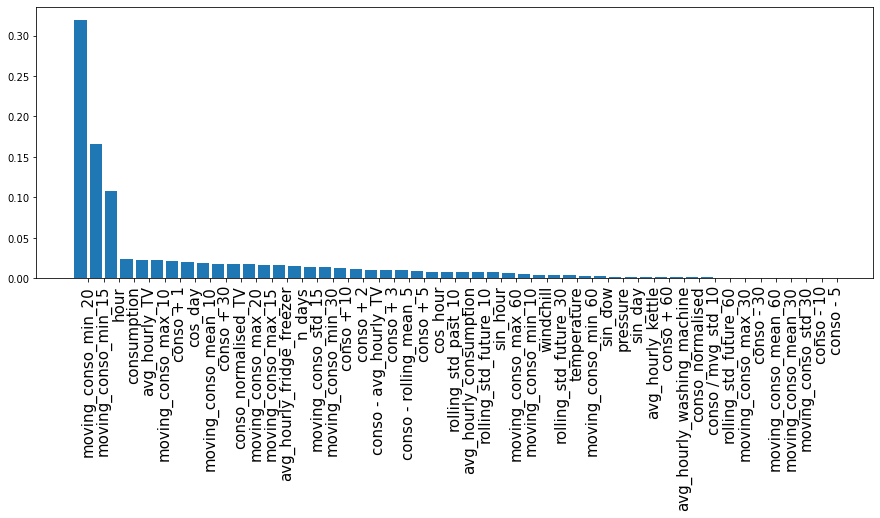

In [0]:
# Looking at the importance of each column and the prediction 
X_columns = X_train2.columns
plt.figure(figsize=(15, 5))

ordering = np.argsort(xgb_reg.feature_importances_)[::-1][:50]
importances = xgb_reg.feature_importances_[ordering]
feature_names = X_columns[ordering]
axis = np.arange(len(feature_names))
plt.bar(axis, importances)
plt.xticks(axis + 0.5, feature_names, rotation=90, fontsize=15);

In [0]:
# Metric nilm TV
pred = xgb_reg.predict(X_test2)
test = y_test2.iloc[:,2]
mt.sqrt(sum((pred - test)**2)/len(test))*14.57/74.86

3.6978107792332855

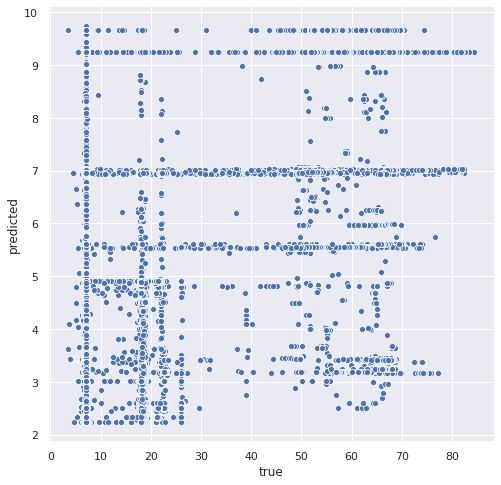

In [0]:
df = pd.DataFrame(pred)
df["true"] = np.array(test)
df.columns = ["predicted","true"]
sns.set(rc={'figure.figsize':(8,8)})
sns.scatterplot(x= "true",y = "predicted", data=df)

In [0]:
#xgb_reg = XGBRegressor(n_estimators=100,
#                       max_depth = 10,
#                       learning_rate=0.1)
#xgb_reg.fit(X2,
#            y2.iloc[:,2],
#            early_stopping_rounds=3)

In [0]:
x_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/data/x_out.csv")
Y_out = pd.read_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_wm_3_full_data.csv")

In [0]:
x_out = x_out[features_TV]

KeyError: ignored

In [0]:
Y_out["TV"] = xgb_reg.predict(x_out)

In [0]:
#Y_out.to_csv("/content/gdrive/My Drive/ML2_final_project/y_out/y_out_TV_4.csv", index=False)